# Enhance Dataset

We need to combine aspects of the additional meta data into the dataset for use in encoding schemes

In [2]:
import os
import copy
import pandas as pd
import seaborn as sns
import webdataset as wds
import matplotlib.pyplot as plt

from datetime import datetime
from dotenv import load_dotenv

In [6]:
sns.set_style('darkgrid')

In [5]:
load_dotenv()

True

## Load data

In [7]:
root = os.getenv('DATA_ROOT')

In [8]:
train_loc = f'file:{root}' + '/dataset/poc2/aerpoc-train-{000000..000029}.tar'
val_loc = f'file:{root}' + '/dataset/poc2/aerpoc-val-{000000..000009}.tar'
test_loc = f'file:{root}' + '/dataset/poc2/aerpoc-test-{000000..000010}.tar'

In [9]:
lens = [44_641, 14_823, 15_112]
base_dir = 'C:/Users/micha/Downloads/aermae/dataset'
columns = [
    'State', 'BlockR', 'BlockC', 'TileId', 'Link',
    'Flying Height in Feet', 'Scale'
]

In [7]:
df_train = pd.read_csv(f'{root}/metadata_train.csv')[columns]
df_test = pd.read_csv(f'{root}/metadata_test.csv')[columns]
df_val = pd.read_csv(f'{root}/metadata_val.csv')[columns]

C:\Users\micha\AppData\Local\Temp\ipykernel_50512\1409805010.py:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_val = pd.read_csv(f'{root}/metadata_val.csv')[columns]


In [8]:
ds_train = (wds.WebDataset(train_loc, shardshuffle=True)
    .shuffle(10_000)
    .decode("pil")
    .to_tuple("jpg", "json")
    .with_length(lens[0]))

ds_val = (wds.WebDataset(val_loc, shardshuffle=False)
    .decode("pil")
    .to_tuple("jpg", "json")
    .with_length(lens[1]))

ds_test = (wds.WebDataset(test_loc, shardshuffle=False)
    .decode("pil")
    .to_tuple("jpg", "json")
    .with_length(lens[2]))

## Enhance Dataset

In [9]:
train_writer = wds.ShardWriter(f'file:{base_dir}/poc/aerpoc-train-%06d.tar', maxcount=13500, compress=True)
val_writer = wds.ShardWriter(f'file:{base_dir}/poc/aerpoc-val-%06d.tar', maxcount=13500, compress=True)
test_writer = wds.ShardWriter(f'file:{base_dir}/poc/aerpoc-test-%06d.tar', maxcount=13500, compress=True)

# writing file:C:/Users/micha/Downloads/aermae/dataset/poc/aerpoc-train-000000.tar 0 0.0 GB 0
# writing file:C:/Users/micha/Downloads/aermae/dataset/poc/aerpoc-val-000000.tar 0 0.0 GB 0
# writing file:C:/Users/micha/Downloads/aermae/dataset/poc/aerpoc-test-000000.tar 0 0.0 GB 0


In [10]:
def crop(img, chunk: int=256, mul: int=2):
    boundary = chunk * mul
    img = img.crop((0, 0, boundary, boundary))
    return img.resize((chunk, chunk), Image.Resampling.BICUBIC)

def split_img(img, chunk: int=256, chunks: int=3) -> list:
    return [
        img.crop((i*chunk, j*chunk, (i+1)*chunk, (j+1)*chunk))
        for i in range(chunks)
        for j in range(chunks)
    ]

def split_coords(box, chunks: int=3):
    index_i = (box[0][0] - box[2][0]) / chunks
    index_j = (box[0][1] - box[2][1]) / chunks

    return [
        [
            [box[0][0] - index_i * i, box[0][1] - index_j * j],
            [box[0][0] - index_i * i, box[0][1] - index_j * (j+1)],
            [box[0][0] - index_i * (i+1), box[0][1] - index_j * (j+1)],
            [box[0][0] - index_i * (i+1), box[0][1] - index_j * j],
            [box[0][0] - index_i * i, box[0][1] - index_j * j]
        ]
        for i in range(chunks-1, -1, -1)
        for j in range(chunks-1, -1, -1)
    ]

def split_meta(meta, chunks: int=3) -> list:
    metas = []

    coords = meta['features'][0]['geometry']['coordinates'][0]
    coords = split_coords(coords, chunks)

    for coord in coords:
        meta = copy.deepcopy(meta)
        meta['features'][0]['geometry']['coordinates'][0] = coord
        metas.append(meta)

    return metas

def get_keymeta(jsn: dict) -> tuple:
    props = jsn['features'][0]['properties']
    return (props['tile_id'], (props['block_r'], props['block_c']))

def correct_dates(meta: dict):
    for feature in meta['features']:
        props = feature['properties']
        date = props['Date']

        if '-' in date:
            date = datetime.strptime(date, "%Y-%m-%d")
            props['Date'] = date.strftime("%Y/%m/%d")

def enhance_meta(meta: dict, usgs_meta: dict):
    for feature in meta['features']:
        props = feature['properties']
        props['scale'] = usgs_meta['Scale']
        props['altitude'] = usgs_meta['Flying Height in Feet']

def get_key(tile: str, block: tuple, index: int) -> str:
    r = str(block[0]).zfill(3)
    c = str(block[1]).zfill(3)
    return f'{tile}_{r}_{c}_{index}'

def get_meta(df, tile: str, block: tuple) -> dict:
    is_block_r = df['BlockR'] == block[0]
    is_block_c = df['BlockC'] == block[1]
    is_tileid = df['TileId'] == tile
    return df[is_tileid & is_block_r & is_block_c].iloc[0]

def transform(img, df, meta) -> dict:
    img = img.convert('L')
    imgs = split_img(img)

    tile, block = get_keymeta(meta)
    #usgs_meta = get_meta(df, tile, block)

    #correct_dates(meta)
    #enhance_meta(meta, usgs_meta)
    metas = split_meta(meta)

    return [
        {
            '__key__': get_key(tile, block, i),
            'jpg': img,
            'json': meta
        }
        for i, (img, meta) in enumerate(zip(imgs, metas))
    ]

def enhance_ds(ds, df, writer):
    for img, meta in ds:
        #img = img.crop((0, 0, 256, 256))
        data = transform(img, df, meta)
        if data is None or len(data) == 0:
            continue

        for row in data:
            writer.write(row)

In [128]:
img, meta = next(iter(ds_test))
imgs = split_img(img)
metas = split_meta(meta)

In [63]:
from shapely import Polygon, MultiPolygon

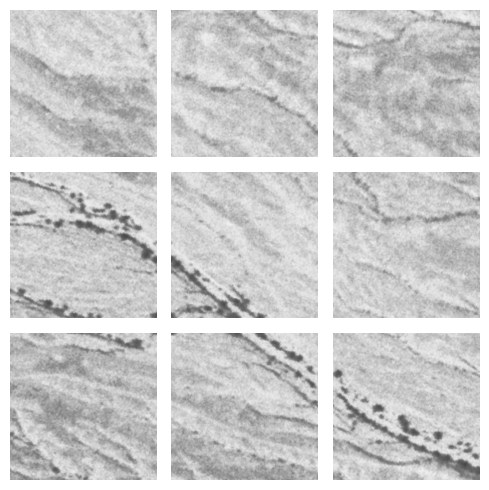

In [104]:

fig, axs = plt.subplots(3, 3, figsize=(5, 5))

for i in range(3):
    for j in range(3):
        img = imgs[i * 3 + j]
        ax = axs[j, i]
        ax.imshow(img)
        ax.axis('off')

plt.tight_layout()
plt.show()

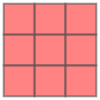

In [137]:
MultiPolygon([
    Polygon(metas[0]['features'][0]['geometry']['coordinates'][0]),
    Polygon(metas[1]['features'][0]['geometry']['coordinates'][0]),
    Polygon(metas[2]['features'][0]['geometry']['coordinates'][0]),
    Polygon(metas[3]['features'][0]['geometry']['coordinates'][0]),
    Polygon(metas[4]['features'][0]['geometry']['coordinates'][0]),
    Polygon(metas[5]['features'][0]['geometry']['coordinates'][0]),
    Polygon(metas[6]['features'][0]['geometry']['coordinates'][0]),
    Polygon(metas[7]['features'][0]['geometry']['coordinates'][0]),
    Polygon(metas[8]['features'][0]['geometry']['coordinates'][0])
])

In [11]:
enhance_ds(ds_train, df_train, train_writer)

# writing file:C:/Users/micha/Downloads/aermae/dataset/poc/aerpoc-train-000001.tar 13500 0.8 GB 13500
# writing file:C:/Users/micha/Downloads/aermae/dataset/poc/aerpoc-train-000002.tar 13500 0.8 GB 27000
# writing file:C:/Users/micha/Downloads/aermae/dataset/poc/aerpoc-train-000003.tar 13500 0.8 GB 40500
# writing file:C:/Users/micha/Downloads/aermae/dataset/poc/aerpoc-train-000004.tar 13500 0.8 GB 54000
# writing file:C:/Users/micha/Downloads/aermae/dataset/poc/aerpoc-train-000005.tar 13500 0.8 GB 67500
# writing file:C:/Users/micha/Downloads/aermae/dataset/poc/aerpoc-train-000006.tar 13500 0.8 GB 81000
# writing file:C:/Users/micha/Downloads/aermae/dataset/poc/aerpoc-train-000007.tar 13500 0.8 GB 94500
# writing file:C:/Users/micha/Downloads/aermae/dataset/poc/aerpoc-train-000008.tar 13500 0.8 GB 108000
# writing file:C:/Users/micha/Downloads/aermae/dataset/poc/aerpoc-train-000009.tar 13500 0.8 GB 121500
# writing file:C:/Users/micha/Downloads/aermae/dataset/poc/aerpoc-train-000010.t

In [12]:
enhance_ds(ds_val, df_val, val_writer)

# writing file:C:/Users/micha/Downloads/aermae/dataset/poc/aerpoc-val-000001.tar 13500 0.7 GB 13500
# writing file:C:/Users/micha/Downloads/aermae/dataset/poc/aerpoc-val-000002.tar 13500 0.8 GB 27000
# writing file:C:/Users/micha/Downloads/aermae/dataset/poc/aerpoc-val-000003.tar 13500 0.7 GB 40500
# writing file:C:/Users/micha/Downloads/aermae/dataset/poc/aerpoc-val-000004.tar 13500 0.8 GB 54000
# writing file:C:/Users/micha/Downloads/aermae/dataset/poc/aerpoc-val-000005.tar 13500 0.7 GB 67500
# writing file:C:/Users/micha/Downloads/aermae/dataset/poc/aerpoc-val-000006.tar 13500 0.8 GB 81000
# writing file:C:/Users/micha/Downloads/aermae/dataset/poc/aerpoc-val-000007.tar 13500 0.7 GB 94500
# writing file:C:/Users/micha/Downloads/aermae/dataset/poc/aerpoc-val-000008.tar 13500 0.8 GB 108000
# writing file:C:/Users/micha/Downloads/aermae/dataset/poc/aerpoc-val-000009.tar 13500 0.8 GB 121500


In [13]:
enhance_ds(ds_test, df_test, test_writer)

# writing file:C:/Users/micha/Downloads/aermae/dataset/poc/aerpoc-test-000001.tar 13500 0.7 GB 13500
# writing file:C:/Users/micha/Downloads/aermae/dataset/poc/aerpoc-test-000002.tar 13500 0.8 GB 27000
# writing file:C:/Users/micha/Downloads/aermae/dataset/poc/aerpoc-test-000003.tar 13500 0.7 GB 40500
# writing file:C:/Users/micha/Downloads/aermae/dataset/poc/aerpoc-test-000004.tar 13500 0.8 GB 54000
# writing file:C:/Users/micha/Downloads/aermae/dataset/poc/aerpoc-test-000005.tar 13500 0.7 GB 67500
# writing file:C:/Users/micha/Downloads/aermae/dataset/poc/aerpoc-test-000006.tar 13500 0.8 GB 81000
# writing file:C:/Users/micha/Downloads/aermae/dataset/poc/aerpoc-test-000007.tar 13500 0.7 GB 94500
# writing file:C:/Users/micha/Downloads/aermae/dataset/poc/aerpoc-test-000008.tar 13500 0.8 GB 108000
# writing file:C:/Users/micha/Downloads/aermae/dataset/poc/aerpoc-test-000009.tar 13500 0.8 GB 121500
# writing file:C:/Users/micha/Downloads/aermae/dataset/poc/aerpoc-test-000010.tar 13500 0

In [14]:
ds_train.close()
ds_val.close()
ds_test.close()

In [15]:
train_writer.close()
val_writer.close()
test_writer.close()

## Sample Enhancements

In [10]:
ds_tmp = (wds.WebDataset(f'file:{base_dir}' + '/poc/aerpoc-train-{000000..000029}.tar', shardshuffle=False)
    .decode("pil")
    .to_tuple("jpg", "json"))

In [11]:
img, meta = next(iter(ds_tmp))

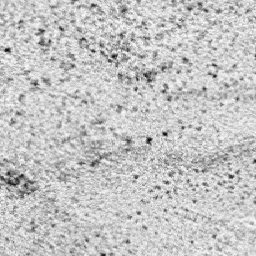

In [12]:
img

In [13]:
meta

{'type': 'FeatureCollection',
 'features': [{'id': '0',
   'type': 'Feature',
   'properties': {'state': 'California',
    'tile_id': 'R11C13',
    'block_r': 213,
    'block_c': 203,
    'index_right': 207,
    'Link': 'https://earthexplorer.usgs.gov/scene/metadata/full/5e83d8e4870f4473/AR1CQ0000130128/',
    'Date': '1947/08/01',
    'Photo_ID': '1CQ0000130128',
    'scale': 37400.0,
    'altitude': 16200.0},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-117.56950114247937, 36.159139529977274],
      [-117.56950114247937, 36.16143921710462],
      [-117.57180082960672, 36.16143921710462],
      [-117.57180082960672, 36.159139529977274],
      [-117.56950114247937, 36.159139529977274]]]}},
  {'id': '1',
   'type': 'Feature',
   'properties': {'state': 'California',
    'tile_id': 'R11C13',
    'block_r': 213,
    'block_c': 203,
    'index_right': 33,
    'Link': 'https://earthexplorer.usgs.gov/scene/metadata/full/5e83d8e4870f4473/AR1CQ0000080056/',
    'Date': '1947/07/15

In [57]:
ds_tmp.close()